In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
excel_file = pd.read_excel('dataset_clean_Weather_bandung_float_AD.xlsx')

In [3]:
df = pd.DataFrame(excel_file)
print(df)

         Tanggal    Tn    Tx  Tavg  RH_avg         RR   ss
0     01-12-2015  21.0  29.0  24.3    81.0   0.000000  8.5
1     02-12-2015  20.0  28.8  23.8    86.0   5.933333  4.1
2     03-12-2015  21.0  28.6  22.8    89.0  11.866667  3.4
3     04-12-2015  20.0  29.4  23.1    88.0  17.800000  2.7
4     05-12-2015  20.0  29.0  23.0    86.0  18.900000  4.5
...          ...   ...   ...   ...     ...        ...  ...
2929  08-12-2023  21.0  30.4  24.9    82.0  12.300000  6.4
2930  09-12-2023  22.4  28.0  24.0    84.0   0.300000  2.3
2931  10-12-2023  21.2  29.8  24.0    82.0   2.000000  1.8
2932  11-12-2023  20.6  32.0  24.0    69.0   4.000000  3.1
2933  12-12-2023  20.6  32.0  24.0    69.0   4.000000  3.1

[2934 rows x 7 columns]


In [4]:
import numpy as np

def konversi_variabel_laju(variabel):
    jumlah_data = len(variabel)
    laju = np.zeros(jumlah_data)

    for i in range(jumlah_data):
        if i == 0:
            laju[i] = variabel[i+1] - variabel[i]
        elif 0 < i < jumlah_data - 1:
            laju[i] = ((variabel[i] - variabel[i-1]) + (variabel[i+1] - variabel[i])) / 2
        elif i == jumlah_data - 1:
            laju[i] = variabel[i] - variabel[i-1]

    return laju

In [5]:
df['laju_Tn'] = konversi_variabel_laju(df['Tn'])
df['laju_Tx'] = konversi_variabel_laju(df['Tx'])
df['laju_Tavg'] = konversi_variabel_laju(df['Tavg'])
df['laju_RH_avg'] = konversi_variabel_laju(df['RH_avg'])
df['laju_RR'] = konversi_variabel_laju(df['RR'])
df['laju_ss'] = konversi_variabel_laju(df['ss'])

In [6]:
print(df)

         Tanggal    Tn    Tx  Tavg  RH_avg         RR   ss  laju_Tn  laju_Tx  \
0     01-12-2015  21.0  29.0  24.3    81.0   0.000000  8.5     -1.0     -0.2   
1     02-12-2015  20.0  28.8  23.8    86.0   5.933333  4.1      0.0     -0.2   
2     03-12-2015  21.0  28.6  22.8    89.0  11.866667  3.4      0.0      0.3   
3     04-12-2015  20.0  29.4  23.1    88.0  17.800000  2.7     -0.5      0.2   
4     05-12-2015  20.0  29.0  23.0    86.0  18.900000  4.5      0.5     -0.7   
...          ...   ...   ...   ...     ...        ...  ...      ...      ...   
2929  08-12-2023  21.0  30.4  24.9    82.0  12.300000  6.4      0.7     -1.7   
2930  09-12-2023  22.4  28.0  24.0    84.0   0.300000  2.3      0.1     -0.3   
2931  10-12-2023  21.2  29.8  24.0    82.0   2.000000  1.8     -0.9      2.0   
2932  11-12-2023  20.6  32.0  24.0    69.0   4.000000  3.1     -0.3      1.1   
2933  12-12-2023  20.6  32.0  24.0    69.0   4.000000  3.1      0.0      0.0   

      laju_Tavg  laju_RH_avg   laju_RR 

In [7]:
# memisahkan fitur input dan output
input_features = ['Tn','Tx','RH_avg','RR','laju_Tn','laju_Tx','laju_RH_avg','laju_RR']
output_features = ['Tn','Tx','RH_avg','RR','laju_Tn','laju_Tx','laju_RH_avg','laju_RR']

In [8]:
# x mengambil data pada df yang fiturnya ada di input_features
# y mengambil data pada df yang fiturnya ada di output_features
x = df[input_features].values
y = df[output_features].values

In [9]:
# normalisasi supaya skalanya konsisten 0-1
# inisialisasi dulu
scaler = MinMaxScaler()

# x_scaled dan y_scaled ini adalah hasil tranformasi
x_scaled = scaler.fit_transform(x)
y_scaled = scaler.fit_transform(y)

In [10]:
# Pemisahan data uji, data latih

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size = 0.2, shuffle=False)
# size disini sebagai berapa banyak data yang akan kita gunakan sebagai data testing
# 0.2 artinya 20% data akan digunakan sebagai data uji dan 80% sebagai data latih
# karena kita menggunakan data time series, maka harus ditambahakan shuffle sbg mencegah terjadinya pengacakan data
# saat kita membagi data menjadi data uji dan data latih, urutannya tidak akan teracak


In [12]:
# timesteps ini adalah panjangnya rentang waktu yang akan digunakan input model LSTM
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

timesteps = 4
# menggunakan data 4 hari sebelumnya menjadi input LSTM

n_features_input = len(input_features)
n_features_output = len(output_features)

In [13]:
# mendefinisikan fungsi
def create_sequences(x, y, time_steps) :
  x_seq, y_seq = [], []

# sebelum mengembalikan nilai para seq, kita akan melakukan iterasi
  for i in range(len(x)-time_steps) : #pengurangan dg timesteps krn data paling terakhir tidak akan bisa di proses
    x_seq.append(x[i : i + time_steps])
    y_seq.append(y[i + time_steps ])

  return np.array(x_seq), np.array(y_seq)

In [14]:
x_train_seq, y_train_seq = create_sequences(x_train, y_train, timesteps)
x_test_seq, y_test_seq = create_sequences(x_test, y_test, timesteps)

In [15]:
# MODEL LSTM4
model = Sequential()

model.add(LSTM(300, input_shape=(timesteps, n_features_input), return_sequences=True))
model.add(LSTM(300, return_sequences=True))  # Layer LSTM tambahan
model.add(LSTM(300, return_sequences=True))  # Layer LSTM tambahan
model.add(LSTM(300))  # Layer LSTM lainnya
model.add(Dense(n_features_output))

#layer output
model.add(Dense(n_features_output))

In [16]:
model.compile(optimizer='adam', loss='mae') # mae bisa ganti rmse atau mse

In [17]:
#fitting, bangun model
hist = model.fit(x_train_seq, y_train_seq, epochs=100, batch_size=30, validation_data=(x_test_seq, y_test_seq),callbacks=[early_stopping])

Epoch 1/100

79/79 [==============================] - 12s 55ms/step - loss: 0.1595 - val_loss: 0.1371
Epoch 2/100
79/79 [==============================] - 3s 37ms/step - loss: 0.1275 - val_loss: 0.1271
Epoch 3/100
79/79 [==============================] - 3s 38ms/step - loss: 0.1215 - val_loss: 0.1262
Epoch 4/100
79/79 [==============================] - 3s 37ms/step - loss: 0.1178 - val_loss: 0.1160
Epoch 5/100
79/79 [==============================] - 3s 38ms/step - loss: 0.1097 - val_loss: 0.1046
Epoch 6/100
79/79 [==============================] - 3s 37ms/step - loss: 0.1018 - val_loss: 0.0947
Epoch 7/100
79/79 [==============================] - 3s 37ms/step - loss: 0.0932 - val_loss: 0.0923
Epoch 8/100
79/79 [==============================] - 3s 38ms/step - loss: 0.0885 - val_loss: 0.0858
Epoch 9/100
79/79 [==============================] - 3s 37ms/step - loss: 0.0820 - val_loss: 0.0780
Epoch 10/100
79/79 [==============================] - 3s 37ms/step - loss: 0.0785 - val_loss: 0.07

[0.15953199565410614, 0.12754058837890625, 0.12147823721170425, 0.1177523136138916, 0.10973342508077621, 0.10175517201423645, 0.09321614354848862, 0.08852112293243408, 0.08199360966682434, 0.078500896692276, 0.07486950606107712, 0.0699087604880333, 0.06396070122718811, 0.060612037777900696, 0.057675279676914215, 0.05715613439679146, 0.05402651056647301, 0.05114318057894707, 0.048319268971681595, 0.047429408878088, 0.04672422632575035, 0.0448584109544754, 0.04580453038215637, 0.04416695609688759, 0.04433022439479828, 0.04370545223355293, 0.043817099183797836, 0.043592553585767746, 0.04504735395312309, 0.04374419525265694, 0.04269842430949211, 0.043119534850120544, 0.04316896200180054, 0.04208124428987503, 0.04301302134990692, 0.04260767251253128, 0.04205368086695671, 0.041876669973134995, 0.0416087880730629, 0.04205469414591789]


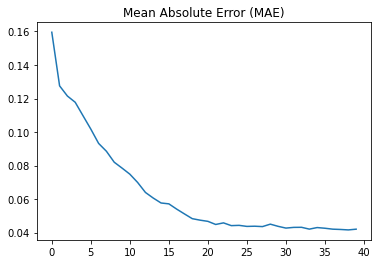

In [18]:
model_history = hist.history
loss = model_history['loss']
print(loss)



plt.figure()
plt.plot(loss, label='MAE')
plt.title('Mean Absolute Error (MAE)')
plt.show()

In [27]:
predictions = model.predict(x_test_seq)
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test_seq)
mae = np.mean(np.abs(predictions-y_test_original), axis=0)
for i, feature in enumerate(output_features):
    print("MAE untuk fitur ", feature, " : ", round(mae[i],3))
    if i == 3:
        break

19/19 [==============================] - 0s 11ms/step
MAE untuk fitur  Tn  :  0.05
MAE untuk fitur  Tx  :  0.136
MAE untuk fitur  RH_avg  :  0.241
MAE untuk fitur  RR  :  0.301


In [28]:
threshold_mae_Tn = (df['Tn'].max() - df['Tn'].min()) * 10 / 100
print("threshold_mae_Tn : ", threshold_mae_Tn)

threshold_mae_Tx = (df['Tx'].max() - df['Tx'].min()) * 10 / 100
print("threshold_mae_Tx : ", threshold_mae_Tx)

threshold_mae_RH_avg = (df['RH_avg'].max() - df['RH_avg'].min()) * 10 / 100
print("threshold_mae_RH_avg : ", threshold_mae_RH_avg)

threshold_mae_RR = (df['RR'].max() - df['RR'].min()) * 10 / 100
print("threshold_mae_RR : ", threshold_mae_RR)

threshold_mae_Tn :  0.5399999999999998
threshold_mae_Tx :  0.7200000000000003
threshold_mae_RH_avg :  3.8
threshold_mae_RR :  2.45


<function matplotlib.pyplot.show(close=None, block=None)>

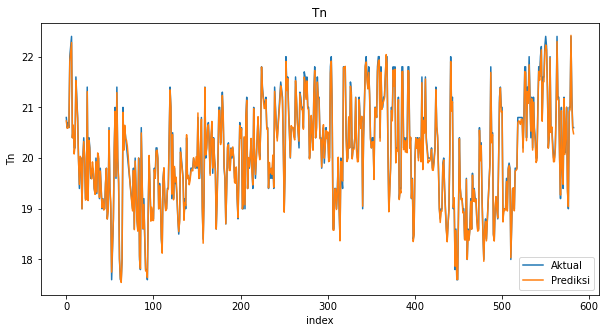

In [29]:
# Plot untuk Tn

target_index = 0 #Tn

plt.figure(figsize=(10,5))
plt.plot(y_test_original[:, target_index], label='Aktual')
plt.plot(predictions[:,target_index], label='Prediksi')
plt.xlabel('index')
plt.ylabel(output_features[target_index])
plt.title('Tn')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

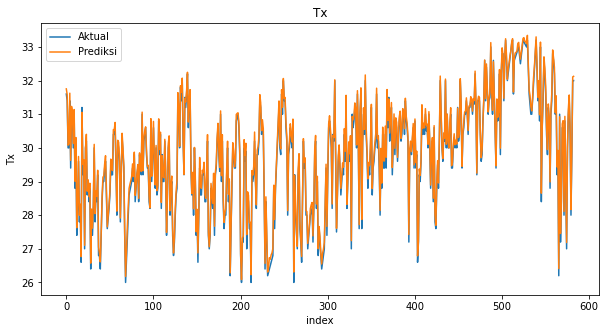

In [30]:
# Plot untuk Tx

target_index = 1 #Tx

plt.figure(figsize=(10,5))
plt.plot(y_test_original[:, target_index], label='Aktual')
plt.plot(predictions[:,target_index], label='Prediksi')
plt.xlabel('index')
plt.ylabel(output_features[target_index])
plt.title('Tx')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

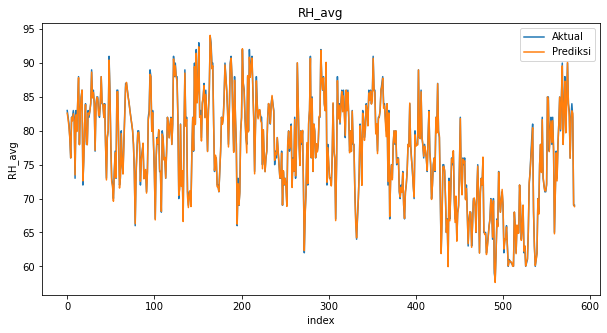

In [31]:
# Plot untuk RH_avg

target_index = 2 #RH_avg

plt.figure(figsize=(10,5))
plt.plot(y_test_original[:, target_index], label='Aktual')
plt.plot(predictions[:,target_index], label='Prediksi')
plt.xlabel('index')
plt.ylabel(output_features[target_index])
plt.title('RH_avg')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

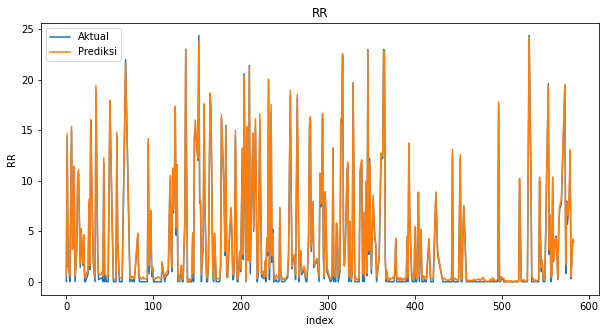

In [32]:
# Plot untuk RR

target_index = 3 #RR

plt.figure(figsize=(10,5))
plt.plot(y_test_original[:, target_index], label='Aktual')
plt.plot(predictions[:,target_index], label='Prediksi')
plt.xlabel('index')
plt.ylabel(output_features[target_index])
plt.title('RR')
plt.legend()
plt.show

In [33]:
# Ambil 24 waktu terakhir dari data Anda
last_24_timesteps = df[input_features].values[-timesteps:]

# Normalisasi menggunakan scaler
last_24_timesteps_scaled = scaler.transform(last_24_timesteps)

# Inisialisasi array untuk menyimpan hasil prediksi
future_predictions = []

# Lakukan prediksi untuk 30 waktu ke depan
for _ in range(30):
    # Reshape untuk sesuai dengan input model
    input_sequence = last_24_timesteps_scaled.reshape(1, timesteps, n_features_input)
    
    # Prediksi satu waktu ke depan
    prediction = model.predict(input_sequence)
    
    # Invers transformasi scaler untuk mendapatkan nilai dalam skala asli
    prediction_inversed = scaler.inverse_transform(prediction)
    
    # Tambahkan prediksi ke dalam array hasil
    future_predictions.append(prediction_inversed.flatten())
    
    # Update sekuens input untuk waktu berikutnya
    last_24_timesteps_scaled = np.concatenate((last_24_timesteps_scaled[1:], prediction), axis=0)

# Konversi hasil prediksi ke dalam DataFrame
future_predictions_df = pd.DataFrame(future_predictions, columns=output_features)

# Tampilkan hasil prediksi
print(future_predictions_df)

1/1 [==============================] - 0s 27ms/step
           Tn         Tx     RH_avg        RR   laju_Tn   laju_Tx  \
0   20.526756  32.079269  68.722298  3.878681  0.143384 -0.576021   
1   20.791496  31.032192  72.069702  1.825824  0.298858 -0.718395   
2   21.045486  30.842657  74.620705  1.161262  0.136250 -0.259034   
3   21.007818  30.700916  76.343697  1.247583 -0.095174 -0.174830   
4   20.800488  30.679918  76.597870  1.739945 -0.136111 -0.182695   
5   20.679731  30.512835  77.069275  1.988332 -0.066260 -0.235873   
6   20.617195  30.384878  77.599358  2.170609 -0.006778 -0.217539   
7   20.619862  30.260704  78.224525  2.240304  0.031909 -0.187924   
8   20.637253  30.201347  78.798820  2.368819  0.032514 -0.150036   
9   20.644358  30.156389  79.245232  2.528618  0.016792 -0.138192   
10  20.632172  30.122147  79.523567  2.672058  0.009198 -0.134686   
11  20.625660  30.085154  79.737549  2.760870  0.015198 -0.132935   
12  20.626823  30.055908  79.923271  2.824346  0.02

In [35]:
P_Tn = []
P_Tx = []
P_Tavg = []
P_RH_avg = []
P_RR = []
P_ss = []
for i in future_predictions_df['Tn']:
    P_Tn.append(round(np.abs(i),2))
for i in future_predictions_df['Tx']:
    P_Tx.append(round(np.abs(i),2))
for i in future_predictions_df['RH_avg']:
    P_RH_avg.append(round(np.abs(i),2))
for i in future_predictions_df['RR']:
    P_ss.append(round(np.abs(i),2))

In [36]:
print(P_Tn)

[20.53, 20.79, 21.05, 21.01, 20.8, 20.68, 20.62, 20.62, 20.64, 20.64, 20.63, 20.63, 20.63, 20.64, 20.65, 20.66, 20.67, 20.68, 20.69, 20.7, 20.71, 20.72, 20.72, 20.73, 20.74, 20.75, 20.75, 20.76, 20.76, 20.77]


In [38]:
model.save("model_weather_4hari_bandung.h5")